As well as defining particular DAG-specific constraints in a constraints file (like obligatory arrows, etc) it is possible to arbitrary MIP constraints on the variables defning the BNSL problem - and to define new variables.

To do this the user just defines a function called `mipconss` in the constraints file. This function takes a single argument which is the current Gobnilp object. Since this is also a Gurobi Model object we can use it to define new variables and constraints.

For example, suppose we had the following in a file called `cons4.py`

```
from gurobipy import GRB

def obligatory_arrows(gobnilp):
    return [('A','E')]

def mipconss(gobnilp):
    orvar = gobnilp.addVar(obj=-1000,vtype=GRB.BINARY)
    gobnilp.addGenConstrOr(orvar, [gobnilp.adjacency[frozenset(['A','B'])],
                                    gobnilp.adjacency[frozenset(['A','F'])],
                                    gobnilp.adjacency[frozenset(['D','E'])]])
```
The `obligatory_arrows` simply states that an arrow from A to E is required. `mipconss`, on the other hand, defines a new binary variable with objective value -1000 and constrains this variable to be true if and only if at least one of 3 adjacencies are the case.

Let first of all learn a BN using `discrete.dat` without consulting `cons4.py`.

Using license file /home/james/gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter PreCrush to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter CutPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter GomoryPasses to 100000
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter ZeroHalfCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPGap to 0.0
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter MIPGapAbs to 0.0
   Prev: 1e-10  Min: 0.0  Max: inf  Default: 1e-10
**********
BN has score -24028.0947783535
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.014444236549
E<-B,F -4310.304956470649
F<- -3470.18794067853
**********
bnlearn modelstring = 
[A][B|A][C][D|A:C][E|B:F][F]
**********
CPD

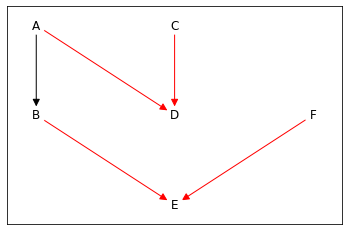

In [1]:
from pygobnilp.gobnilp import Gobnilp
m = Gobnilp()
m.learn('discrete.dat',palim=None)

And now let's relearn using the constraints in `cons4.py`

**********
BN has score -24831.592997736785
**********
A<- -5502.137377150637
B<-D,E -4084.0547874724034
E<-A -5255.121003198736
D<-A,C -3555.014444236549
C<- -3501.5105385969146
F<-B,E -2933.7548470815454
**********
bnlearn modelstring = 
[A][B|E:D][E|A][D|A:C][C][F|E:B]
**********
CPDAG:
Vertices: A,B,E,D,C,F
A->D
A->E
B->F
E->B
E->F
D->B
C->D



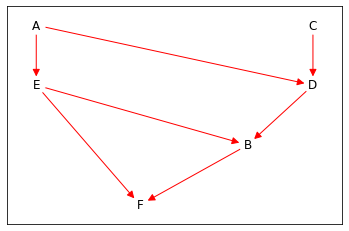

In [2]:
m.learn('discrete.dat',palim=None,consfile='cons4')

Sure enough, the required arrow from A to E is there. None of the adjacencies mentioned in the 'or' constraint are found in the learned DAG which is not surprising since that would attract a penalty of 1000.

If we we now to edit `cons4.py` so that 'or' variable has objective of +10000, we get the following DAG.

**********
BN has score -24093.68982888259
**********
A<- -5502.137377150637
B<-A -3688.9395212202216
C<- -3501.5105385969146
D<-A,C -3555.014444236549
E<-A,B -4912.333100596723
F<-B,E -2933.7548470815454
**********
bnlearn modelstring = 
[A][B|A][C][D|A:C][E|B:A][F|E:B]

 ** MIP solution objective is -23093.68982888259 ** 

**********
CPDAG:
Vertices: A,B,C,D,E,F
A-B
A->D
A->E
B-E
B-F
C->D
E->F



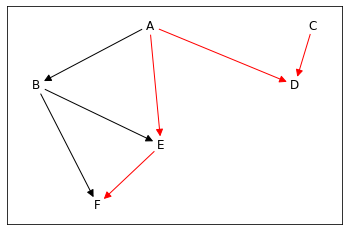

In [4]:
m.learn('discrete.dat',palim=None,consfile='cons4')

So now we get A and B connected. We also get a message that the objective value achieved by solving the MIP is 1000 better than the score of the BN. This is because the extra non-graphical 'or' variable has (invisibly) been set to 1.